In [1]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from gensim.models import Word2Vec
import umap # pip install umap-learn
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import tools as tl

c:\ProgramFiles\Anaconda3\envs\nlp10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the 20 newsgroups dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

df_train = pd.DataFrame({'text': newsgroups_train.data, 'label': newsgroups_train.target})
df_test = pd.DataFrame({'text': newsgroups_test.data, 'label': newsgroups_test.target})

df_train['label'] = df_train['label'].map(lambda x: newsgroups_train.target_names[x])
df_test['label'] = df_test['label'].map(lambda x: newsgroups_test.target_names[x])

df_train = df_train[df_train['label'].isin(['rec.sport.baseball', 'comp.graphics', 'sci.space', 'talk.religion.misc'])]
df_test = df_test[df_test['label'].isin(['rec.sport.baseball', 'comp.graphics', 'sci.space', 'talk.religion.misc'])]

In [3]:
len(df_train), len(df_test)

(2151, 1431)

In [4]:
# df_train = df_train.sample(300)
# df_test = df_test.sample(100)
len(df_train), len(df_test) # reduce the number of samples if necessary

(2151, 1431)

In [5]:
# Apply tokenizer
df_train['tokens'] = df_train['text'].apply(tl.tokenize)
df_test['tokens'] = df_test['text'].apply(tl.tokenize)

In [6]:
w2v_model = Word2Vec(sentences=df_train['tokens'], vector_size=100, window=5, min_count=1, workers=4)
w2v_model.save("news_word2vec.model")

In [7]:
import numpy as np

def get_text_embedding(tokens, model):
    embeddings = []
    for token in tokens:
        if token in model.wv:
            embeddings.append(model.wv[token])
    if len(embeddings) == 0:
        return np.zeros(model.vector_size)
    return np.mean(embeddings, axis=0)

df_train['embedding'] = df_train['tokens'].apply(lambda tokens: get_text_embedding(tokens, w2v_model))
df_test['embedding'] = df_test['tokens'].apply(lambda tokens: get_text_embedding(tokens, w2v_model))

In [12]:
import umap

embeddings = np.vstack(df_train['embedding'].values)

umap_model = umap.UMAP(n_components=2, random_state=2024)  # Set n_components=2 for 2D projection, or 3 for 3D
umap_embeddings = umap_model.fit_transform(embeddings)
umap_embeddings_test = umap_model.transform(np.vstack(df_test['embedding'].values))

df_train['umap_1'] = umap_embeddings[:, 0]
df_train['umap_2'] = umap_embeddings[:, 1]

df_test['umap_1'] = umap_embeddings_test[:, 0]
df_test['umap_2'] = umap_embeddings_test[:, 1]

c:\ProgramFiles\Anaconda3\envs\nlp10\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


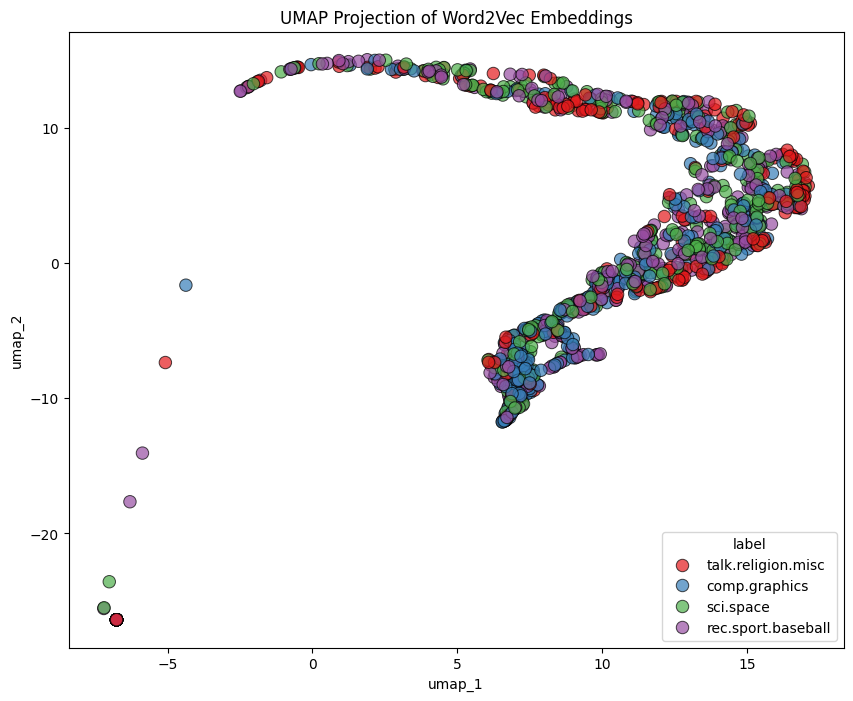

In [13]:
# Plot the UMAP results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='umap_1', y='umap_2', hue='label', data=df_test, palette='Set1', s=80, edgecolor='k', alpha=0.7)

plt.title('UMAP Projection of Word2Vec Embeddings')
plt.show()


In [14]:
from sklearn.metrics import silhouette_score

algos = ['kmeans', 'hdbscan', 'agg', 'spectral', 'gmm', 'dbscan']

word2vec_embeddings_test = np.vstack(df_test['embedding'].values)
# umap_embeddings_test # calculated earlier

results_df = pd.DataFrame(columns=["Number of clusters", "Silhouette Score"])

for algo in algos:
  umap_clusters = tl.perform_clustering_without_PCA(umap_embeddings_test, algo=algo)
  word2vec_clustrs = tl.perform_clustering_without_PCA(word2vec_embeddings_test, algo=algo)

  results_df.loc[f"{algo} (UMAP)"] = tl.calc_cluster_metrics(umap_clusters, umap_embeddings_test)
  results_df.loc[f"{algo} (Word2Vec)"] = tl.calc_cluster_metrics(word2vec_clustrs, word2vec_embeddings_test)

results_df

c:\ProgramFiles\Anaconda3\envs\nlp10\lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


,Number of clusters,Silhouette Score
kmeans (UMAP),5.0,0.554122
kmeans (Word2Vec),5.0,0.470782
hdbscan (UMAP),2.0,0.674647
hdbscan (Word2Vec),2.0,0.697429
agg (UMAP),5.0,0.491545
agg (Word2Vec),5.0,0.466261
spectral (UMAP),5.0,0.342129
spectral (Word2Vec),5.0,0.449555
gmm (UMAP),5.0,0.470693
gmm (Word2Vec),5.0,0.069928
